# ASTR 596: The Midterm

#### 5 parts, 20 pts each. Some parts are easier than others, so are essentially free points, but you'll need to solve the earlier parts correctly to get the right answer on the later parts. I'd strongly recommend skimming the Riess et al. 2011 paper. 

#### We've been building up our ability to deal with complex data, and you've now got the ability to fit straight lines with frequentist tools (as you did with the Cepheids), and infer constraints on more complex high-dimensional models given the data with MCMC. So let's combine the two and infer one of the most important numbers in the Universe - the Hubble constant.

#### There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

#### Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file `R11ceph.dat`.

In [1]:
exec(open('cepheids.py').read())
ceph = Cepheids('R11ceph.dat')
hosts = ceph.list_hosts()

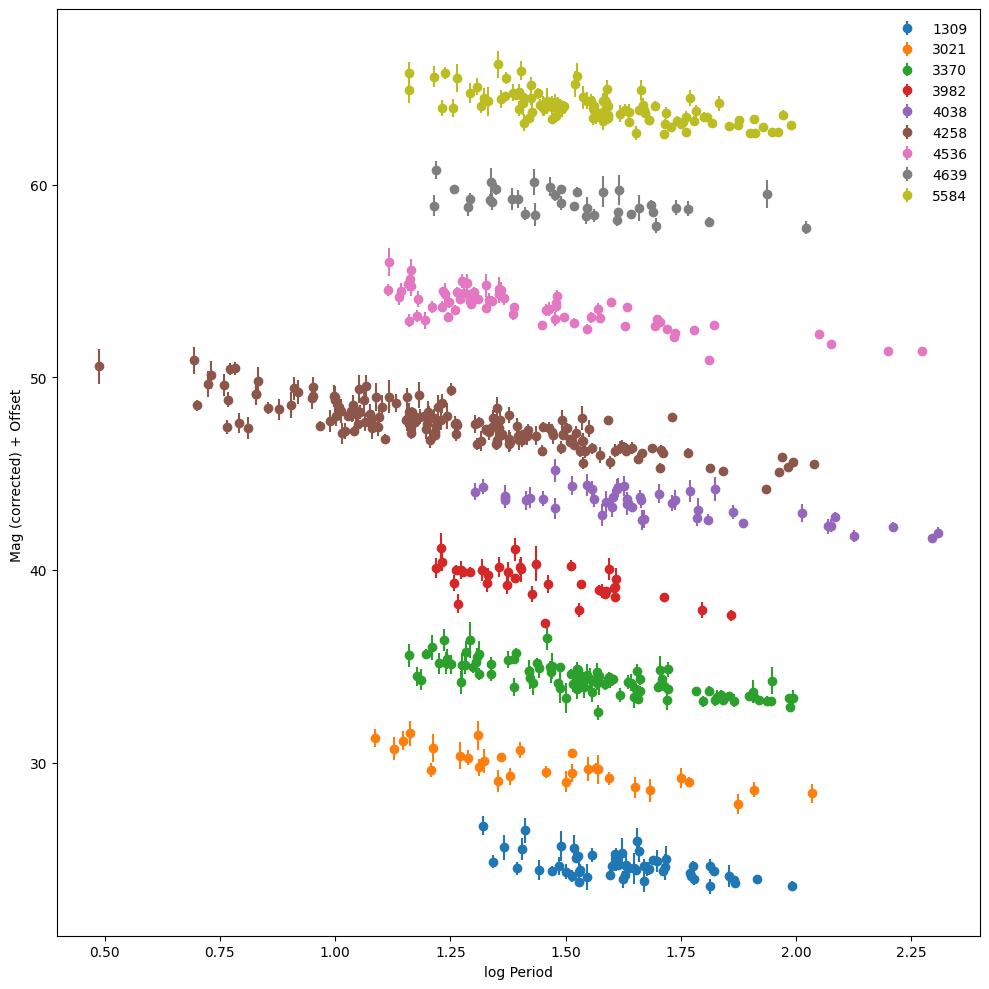

In [2]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period error (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


From Riess et al. (2011):

$$ m_{W,i,j} = (\mu_{0,i} - \mu_{0, 4258}) + zp_{W, 4258} + b_W \log_{10}(P_{i,j}) $$

Using a Gaussian likelihood:

$$ L = \prod_{i} \frac{1}{\sqrt{2\pi \sigma_i^2}} \exp\left( -\left( \frac{y_i - f(x_i)}{\sigma_i} \right)^2 \right) $$
for a model $f(x)$ and data $\{x_i, y_i, \sigma_i \}$




Plugging in:
$$
-ln(L) = \sum_{i,j} ln(\sigma_{W,i,j}) + 0.5 \ ln(2 \pi) + \left( \frac{ m_{W,i,j} - (\mu_{0,i} - \mu_{0,4258}) - zp_{W,4258} - b_W \log_{10}(P_{i,j}) }{\sigma_{W,i,j}} \right)^2
$$
where $\sigma_{W,i,j}$ is the uncertainty in $m_{W,i,j}$

# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

**Priors needed:**
$(\mu_{0,i} - \mu_{0,2458})$, $zp_{W,2458}$, $b_W$

$zp_{W,4258}$ is the intercept of the P-L relation, common to all galaxies. Wagner-Kaiser et al. (2015) find a median intercept of $\sim 21$, and Gieren et al. (1997) find a median intercept of $\sim 13$. I use a normal prior considering both results:
$zp_{W,4258} \sim N(17, 5)$




$b_W$ is the slope of the P-L relation, the same for all galaxies. Sandage & Tammann (2008) claim a median slope of $\sim -2.75$ and Lanoix et al. (1999) cite a value of $\sim -2.77$. Based on these, I use a normal prior: 
$b_W \sim N(-2.75, .5)$




$\Delta \mu_{i} \equiv (\mu_{0,i} - \mu_{0,4258})$ is the distance modulus (difference), specific for each galaxy (except 4258). For each galaxy, I look up distance modulus $\mu_0$ estimates from the literature. I then use a prior of a normal distribution centered on $\hat{\mu_{0,i}} - \mu_{0, 4028}$ with a wide spread of $\sigma =1$.
$\Delta \mu_i \sim N( \hat{\mu_{0,i}} - \mu_{0, 4258}, 1 )$


Reported distance moduli $\mu_0$:

* NGC1309 - 32.471 (Jang & Lee 2017)
* NGC3021 - 32.178 (Jang & Lee 2017)
* NGC3370 - 32.253 (Jang & Lee 2017)
* NGC3982 - 31.559 (Stetson & Gibson 2001)
* NGC4038 - 31.74 (Schweizer et al. 2008)
* NGC4536 - 30.29 (Buta & Turner 1982)
* NGC4639 - 32.03 (Saha et al. 1996)
* NGC5584 - 31.81 (Javanmardi et al. 2021)

# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

In [250]:
%matplotlib inline

import numpy
import corner 
import emcee

from multiprocessing import Pool

In [251]:
import matplotlib as mpl

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['ytick.major.size'] = 7
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.minor.size'] = 3

In [252]:
def dist2mu(dist):
    return 5*np.log10(dist/10)

def model(zp, b, mu, logP):
    return zp + mu + b*logP

### Likelihood

In [253]:
def log_likelihood(theta, ceph):
    
    hosts = ceph.list_hosts()
    ngal = len(hosts)
    llike = 0
    
    
    for i in range(ngal):
        ceph.select(hosts[i])
        
        x = ceph.logP
        y = ceph.mobs
        yerr = ceph.sigma
        
        if i < 5:
            ind = i
        else:
            ind = i-1
        
        #Do 4258
        if i == 5:
            dy = y - model(theta[0], theta[1], 0, x)
    
            llike += np.sum( -np.log(yerr) - np.log(2*np.pi) - dy**2/yerr**2/2)

        else:
            dy = y - model(theta[0], theta[1], theta[2+ind], x)
    
            llike += np.sum( -np.log(yerr) - np.log(2*np.pi) - dy**2/yerr**2/2)
        
    return llike

### Prior

In [254]:
def norm_logpdf(x, mu, sigma):
    return -np.log(sigma) - np.log(2*np.pi)/2 - (x-mu)**2/sigma**2/2

def uniform_logpdf(x, a, b):
    if (x <= b) & (x >= a):
        return -np.log(b-a)
    else:
        return -np.inf


def log_prior(theta):
    
    ngal = len(theta) - 3
    mu_4258 = dist2mu(7.6*1e6)  #From Humphreys et al. (2013)
    
    mu_est = [32.471, 32.178, 32.253, 31.559, 31.74, 30.29, 32.03, 31.81]
    lpri = 0
    
    #For zp
    lpri += norm_logpdf(theta[0], 17, 5)
    
    #For bw
    lpri += norm_logpdf(theta[1], -2.75, .5)
    
    for i in range(ngal):        
        if i < 5:
            ind = i
        else:
            ind = i-1
        
        #For mu
        lpri += norm_logpdf(theta[ind+2], mu_est[i] - mu_4258, 1)
    
    return lpri

### Run sampling

In [255]:
def log_posterior(theta, ceph):
    
    lpri = log_prior(theta)
    llike = log_likelihood(theta, ceph)
    return lpri + llike


def make_guesses(size, ndim):
    ngal = ndim - 2
    guesses = np.zeros( (ndim, size) )
    
    #For zp
    guesses[0, :] = np.random.normal( 17, 5, size )
    
    #For bW
    guesses[1, :] = np.random.normal( -2.75, .5, size)
    
    for i in range(ngal):
        #For mu
        guesses[i + 2, :] = np.random.uniform(0, 5, size)
        
    
    return guesses

In [257]:
def sample_mcmc(ceph, nwalker, nchain):
    
    ndim = len(ceph.list_hosts()) - 1 + 2
    
    guesses = make_guesses(nwalker, ndim).T
    
    with Pool(30) as pool:
        sampler = emcee.EnsembleSampler(nwalker, ndim, log_posterior, args=[ceph])
        _ = sampler.run_mcmc(guesses, nchain, progress=True)
    
    return sampler

In [258]:
sampler = sample_mcmc(ceph, 50, 10000)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:36<00:00, 25.19it/s]


### Trace plots

In [286]:
titles = ["$zp_{W, 4258}$", "$b_W$"]
for i in range(len(hosts)):
    if i == 5:
        continue
        
    titles.append( "$\Delta\mu_{" + "{}".format(hosts[i]) + "}$" )

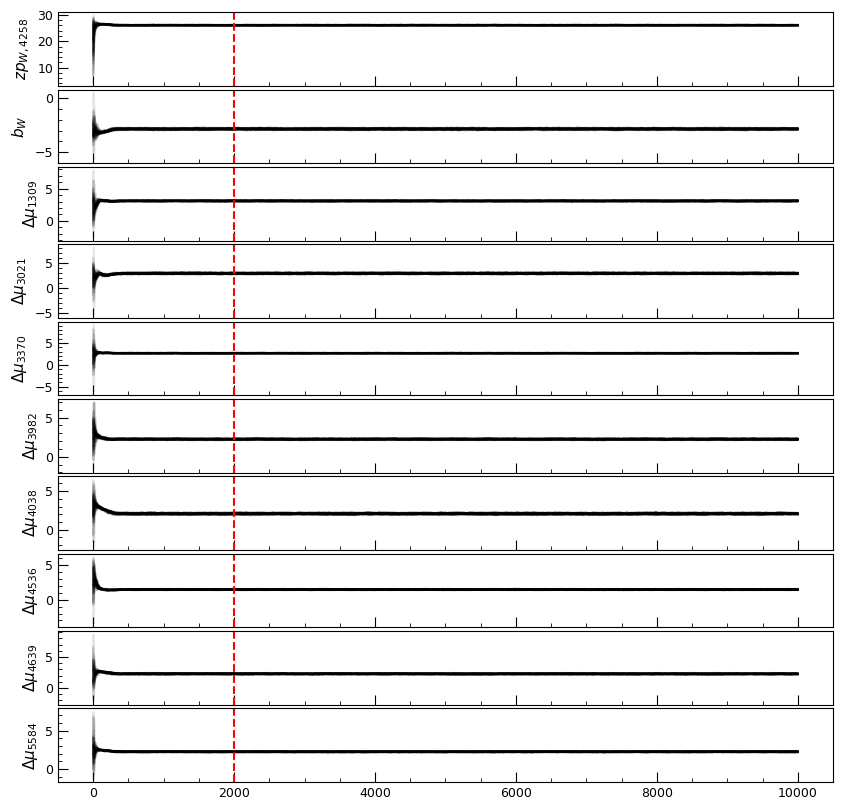

In [327]:
nburn = 2000
samples = sampler.get_chain()

fig, ax = plt.subplots(samples.shape[2], 1, figsize=(10, samples.shape[2]), sharex=True)

for i in range(len(ax)):
    for j in range(samples.shape[1]):
        ax[i].plot(samples[:,j,i], color='k', alpha=.1)
    ax[i].set_ylabel(titles[i], fontsize=11)
    ax[i].axvline(nburn, ls='--', color='r')
    ax[i].tick_params('both', labelsize=9)
    
plt.subplots_adjust(hspace=.05)
plt.show()

I'm using a conservative $N_{burn} = 2000$, even though it seems the chains settle by $N\approx250$, just to make sure.

### Corner plot

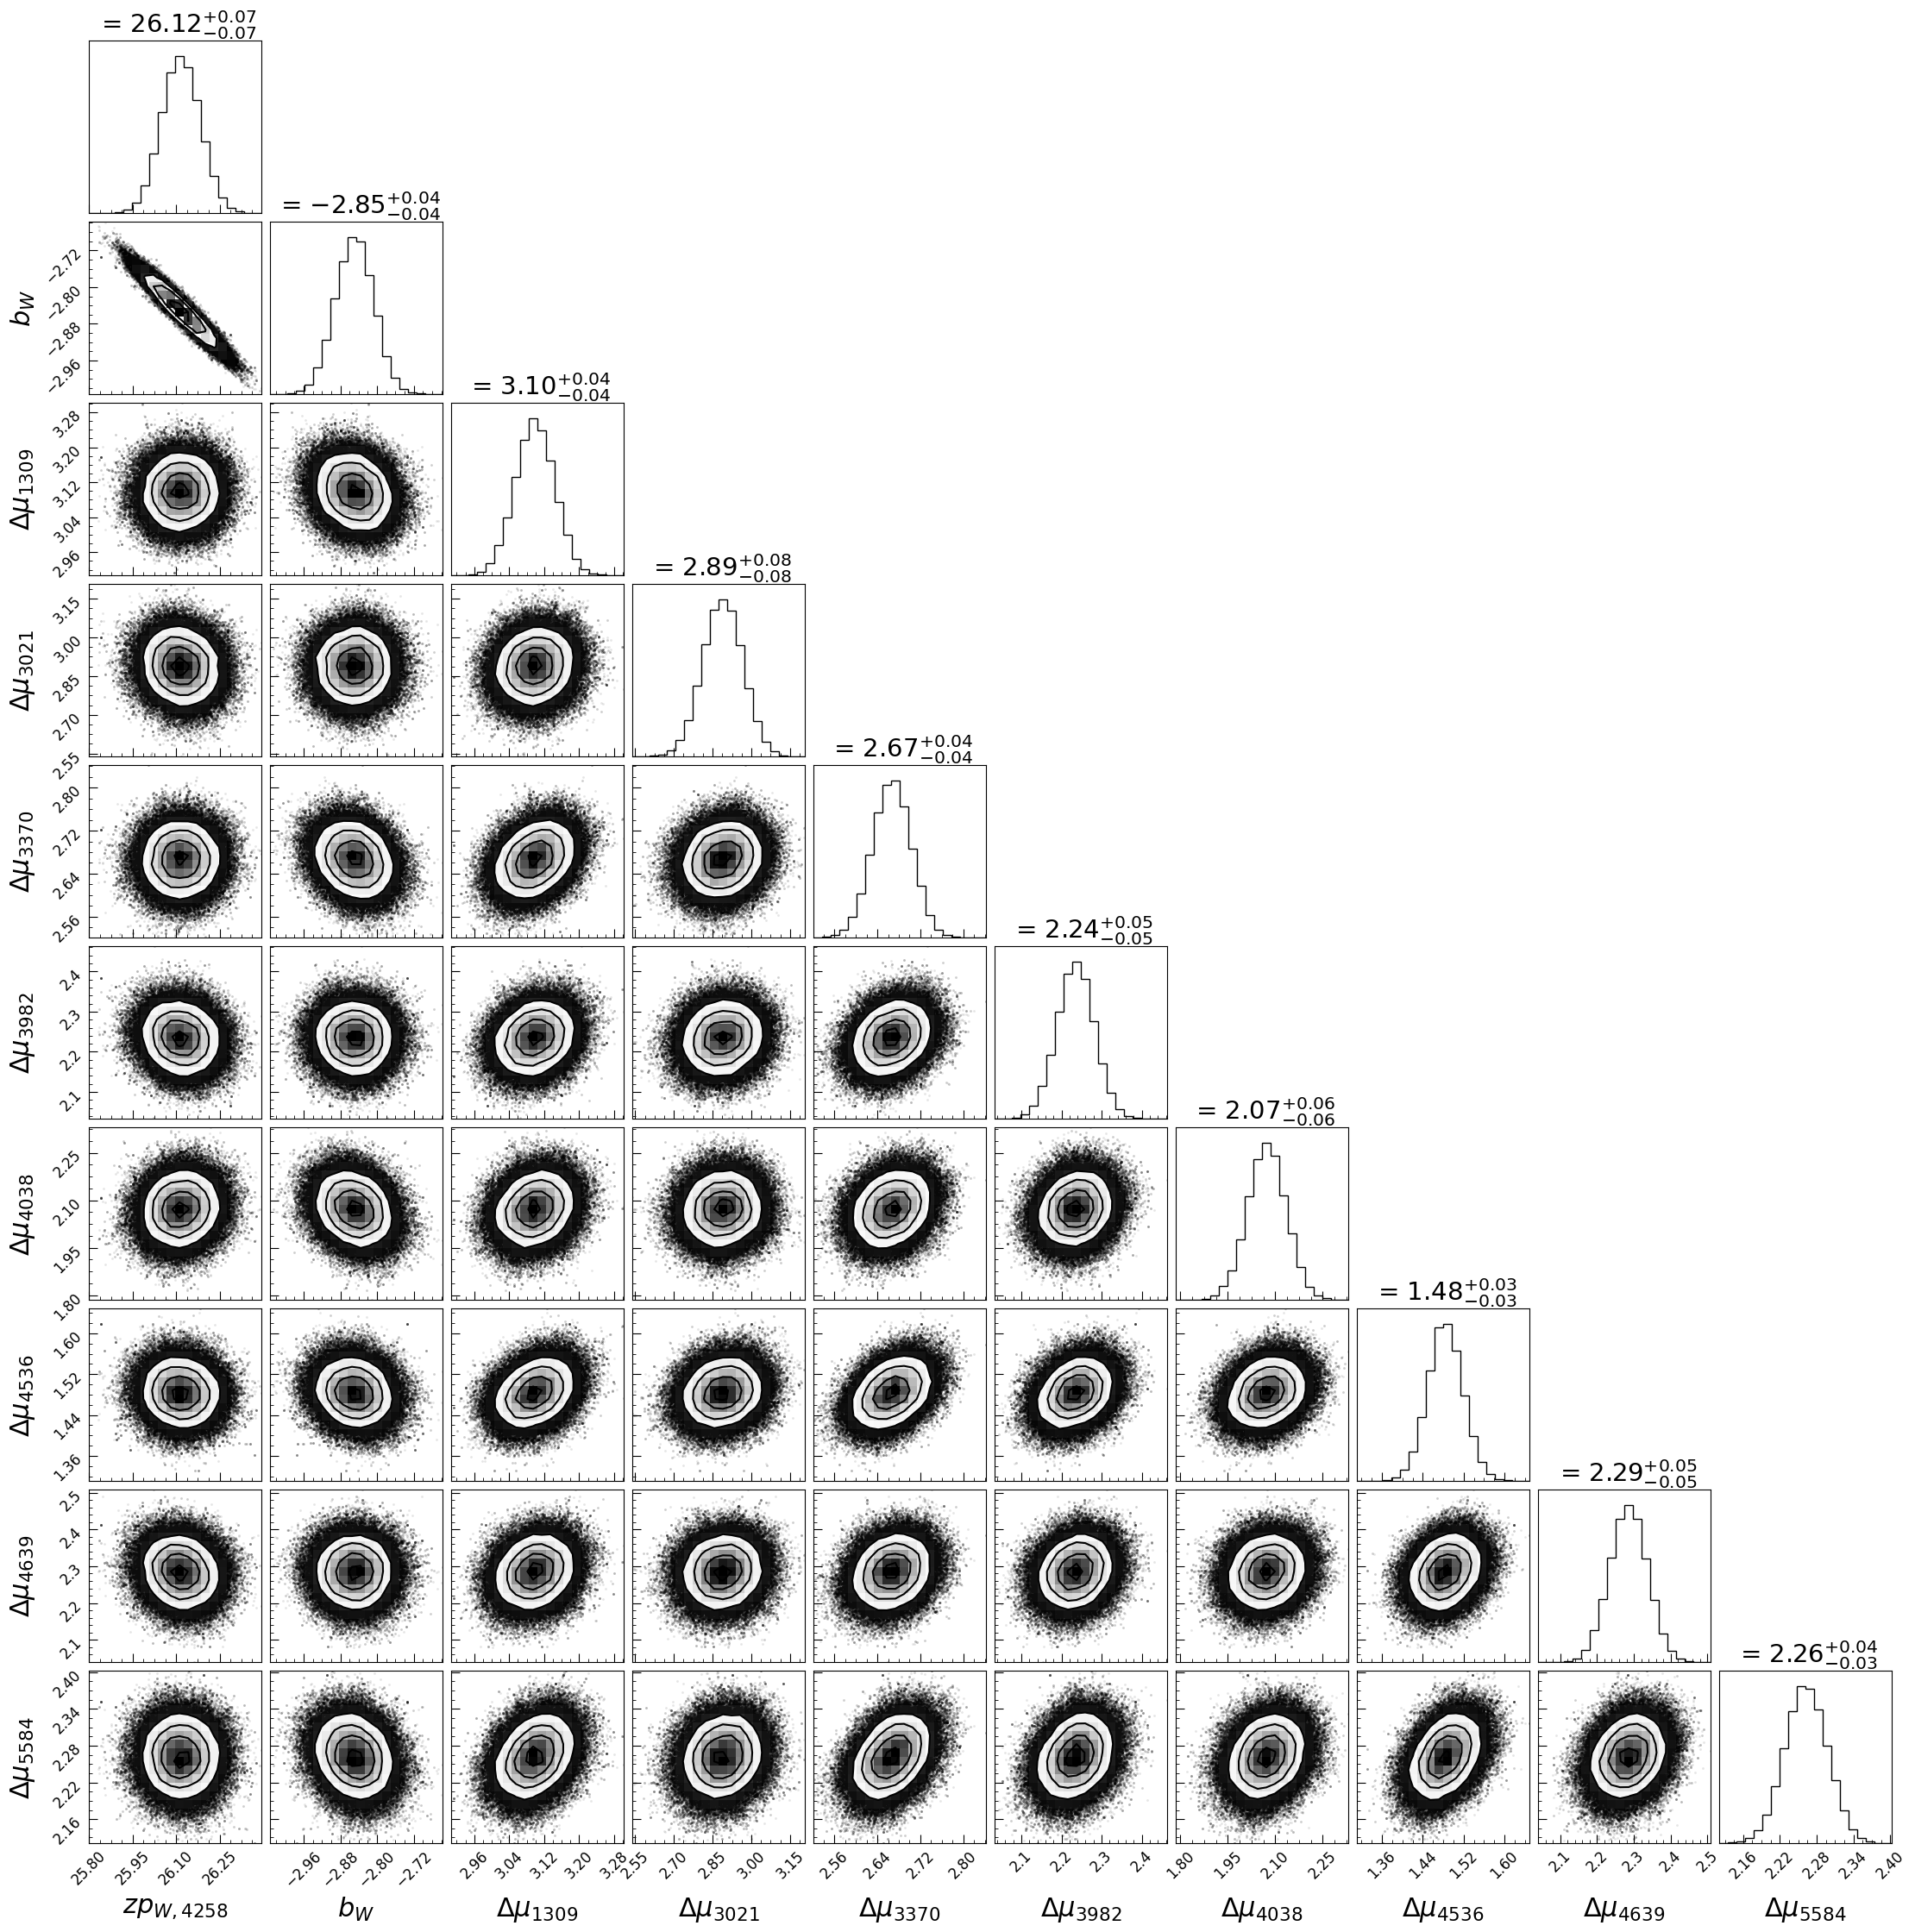

In [328]:
corner.corner(sampler.get_chain(flat=True, discard=nburn), labels=titles, 
              plot_contours=True, show_titles=True,
              titles=np.full(samples.shape[2], ''), 
              label_kwargs={'fontsize':22}, title_kwargs={'fontsize':21});

### Comparison of $\mu_{0,i} - \mu_{0, 4258}$ to Riess et al. (2011)

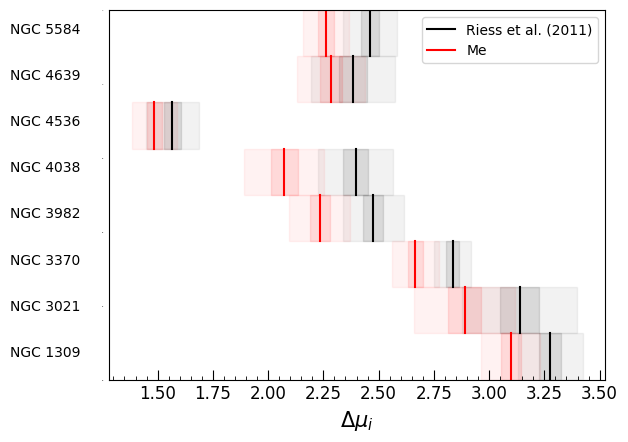

In [364]:
hosts = ceph.list_hosts().copy()
hosts = np.delete(hosts, 5)


riess_vals = [3.276, 3.138, 2.835, 2.475, 2.396, 1.567, 2.383, 2.461]
riess_errs = [.0491, .0870, .0284, .0460, .0567, .0404, .0630, .0401]

samples = sampler.get_chain(flat=True, discard=nburn)
my_vals = []
my_errs_hi = []
my_errs_lo = []


for i in range(8):
    my_vals.append( np.median(samples[:,2+i]) )
    my_errs_hi.append( np.percentile(samples[:,2+i], 84) - my_vals[-1] )
    my_errs_lo.append( my_vals[-1] - np.percentile(samples[:, 2+i], 16) )
    

    
fig, ax = plt.subplots()
for i in range(8):
    
    ymin = (2*i+1)/16 - 1/16
    ymax = (2*i+1)/16 + 1/16
    ytxt = (2*i+1)/16
    
    if i == 7:
        label1 = 'Riess et al. (2011)'
        label2 = 'Me'
    else:
        label1 = ''
        label2 = ''
    
    ax.axvline(riess_vals[i], ymin=ymin, ymax=ymax, color='k', label=label1)
    ax.axvline(my_vals[i], ymin=ymin, ymax=ymax, color='r', label=label2)
    
    ax.axvspan( riess_vals[i]-riess_errs[i], riess_vals[i]+riess_errs[i], ymin=ymin, ymax=ymax, color='k', alpha=.1 )
    ax.axvspan( my_vals[i]-my_errs_lo[i], my_vals[i]+my_errs_hi[i], ymin=ymin, ymax=ymax, color='r', alpha=.1 )
    
    ax.axvspan( riess_vals[i]-3*riess_errs[i], riess_vals[i]+3*riess_errs[i], ymin=ymin, ymax=ymax, color='k', alpha=.05 )
    ax.axvspan( my_vals[i]-3*my_errs_lo[i], my_vals[i]+3*my_errs_hi[i], ymin=ymin, ymax=ymax, color='r', alpha=.05 )
    

    plt.figtext(-.2, ytxt, 'NGC ' + hosts[i], transform=ax.transAxes)
    
ax.tick_params('y', which='both', labelsize=0, length=0)
ax.set_xlabel(r'$\Delta\mu_i$', fontsize=15)
    
plt.legend()
plt.show()

On this plot, the lines indicate the median values, the darker shaded region indicates $\pm 1\sigma$, and the lighter shaded region indicates $\pm 3\sigma$.

The graph shows that most values are within $3\sigma$ of each other, but not within $1\sigma$. The difference can be ascribed to either a lack of samples needed to properly sample the parameter posteriors, the fact that we did not include the metallicity term, or that we didn't fit the SNe data simultaneously.

### Recreate Fig. 7 of Riess et al. (2011)

In [367]:
def plot_line_fits(ceph, sampler, nburn, skip=0):
    
    hosts = ceph.list_hosts()
    fchain = sampler.get_chain(flat=True, discard=nburn, thin=skip)
    fchain_tot = sampler.get_chain(flat=True, discard=nburn)
    
    
    ncol = 3
    nrow = len(hosts)//ncol
    
    fig, ax = plt.subplots(nrow, ncol, figsize=(4*ncol, 4*nrow))
    
    
    y1 = np.min( ceph.data[:,2] - ceph.data[:,3] )
    y2 = np.max( ceph.data[:,2] + ceph.data[:,3] )
    
    for i in range(len(hosts)):
        ceph.select(hosts[i])
        x = ceph.logP
        y = ceph.mobs
        yerr = ceph.sigma

        if i < 5:
            mu_vals = fchain[:,2+i]
            mu_vals_tot = fchain_tot[:, 2+i]
        elif i > 5:
            mu_vals = fchain[:, 2+i-1]
            mu_vals_tot = fchain_tot[:, 2+i-1]
        else:
            mu_vals = np.zeros(fchain.shape[0])
            mu_vals_tot = np.zeros(fchain.shape[0])
        
        
        row_ind = i//ncol
        col_ind = i%ncol
        
        _, _, bars = ax[row_ind, col_ind].errorbar(x, y, yerr, fmt='.k', ms=3)
        [bar.set_alpha(.3) for bar in bars]
        
        x1, x2 = ax[row_ind, col_ind].get_xlim()
        x_line = np.linspace(x1, x2, 1000)
        
        ylines = np.zeros(( len(fchain), 1000 ))
        for j in range(len(fchain)):
            ylines[j, :] = model(fchain[j,0], fchain[j,1], mu_vals[j], x_line)
        
        #3sigma
        yline_hi = np.percentile( ylines, 50 + 99.7/2, axis=0 )
        yline_mid = model( np.median(fchain_tot[:,0]), np.median(fchain_tot[:,1]), np.median(mu_vals_tot), x_line )
        yline_lo = np.percentile( ylines, 50 - 99.7/2, axis=0 )
        
        ax[row_ind, col_ind].plot(x_line, yline_mid, color='orange')
        ax[row_ind, col_ind].fill_between(x_line, yline_lo, yline_hi, color='orange', alpha=.3)
        
        ax[row_ind, col_ind].set_title('NGC ' + hosts[i])
        
        if col_ind == 0:
            ax[row_ind, col_ind].set_ylabel("$m_W$", fontsize=15)
            
        if row_ind == nrow - 1:
            ax[row_ind, col_ind].set_xlabel("$\log_{10}(P)$", fontsize=15)
            
        ax[row_ind, col_ind].invert_yaxis()
        
        
    plt.subplots_adjust(wspace=.2, hspace=.3)
    plt.show()
    return
    

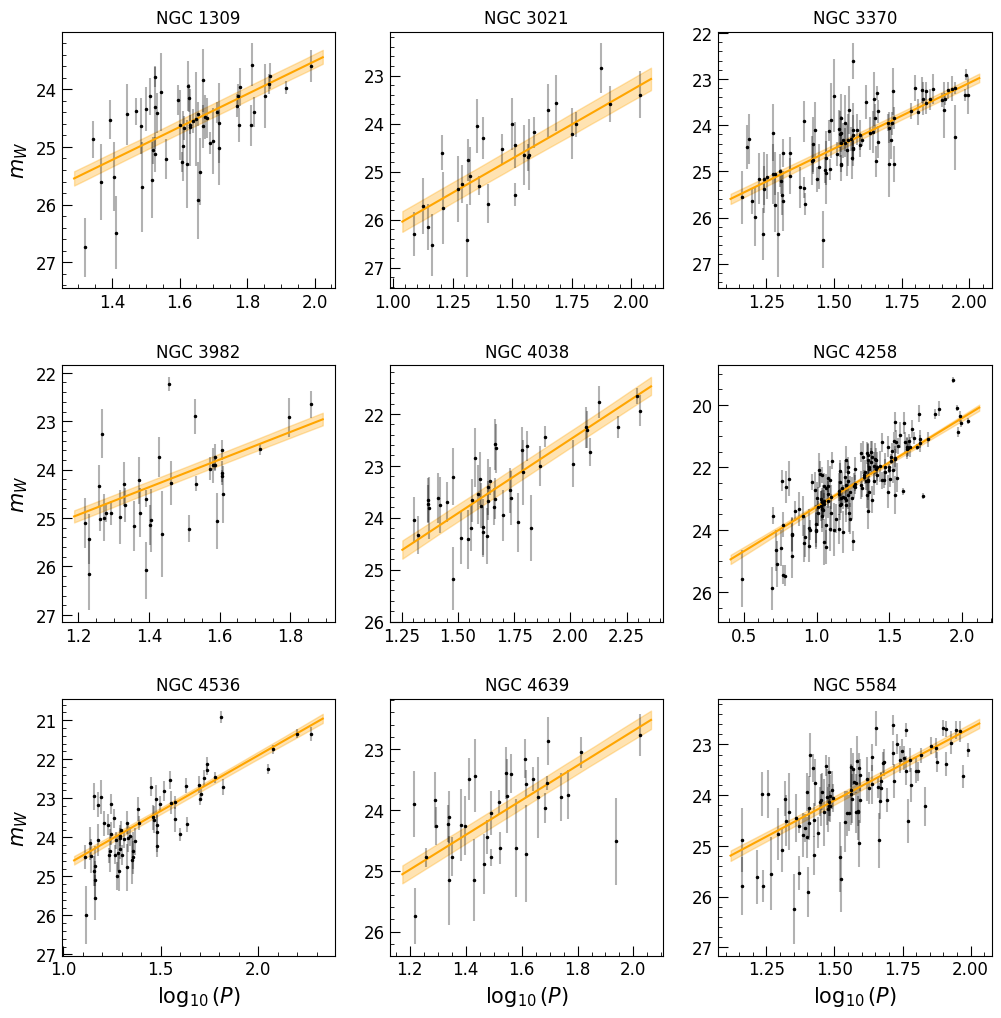

In [368]:
plot_line_fits(ceph, sampler, nburn, skip=100)

Shaded regions show the $\pm 3\sigma$ deviations from the median linear fit (shown as the orange line).

# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

To fit $H_0$ directly, replace $\Delta\mu_i$ with the formula from Q1 in Eqn. 3. Then plug into Eqn. 4 to get:

$$
m_{W,i,j} = (m^0_{v,i} + 5a_v) + zp_{W,2458} + b_W \log_{10}(P_{i,j}) - 5\log_{10}(H_0) - \mu_{0,2458} + 25
$$


Plug Eqn. 3 into Eqn. 4 directly to get:

$$
\log_{10}(H_0) = \frac{ (m^0_{v,i} + 5a_v) - \Delta \mu_i - \mu_{0,4258} + 25 }{5}
$$

where $\Delta\mu_i \equiv \mu_{0,i} - \mu_{0, 4258}$ and $(m^0_{v,i} + 5a_v)$ can be obtained from Table 3. For this, we can plug in the $\Delta\mu_i$ samples from the MCMC run.

# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.

In [365]:
#Plug in the emcee samples to the equation from Q4 to get samples for H0

samples = sampler.get_chain(flat=True, discard=nburn)
sn_vals = np.array([16.768, 16.699, 16.545, 15.953, 15.901, 15.147, 16.040, 16.274])
mu_4258 = dist2mu(7.6*1e6)

H0_samples = []

hosts = ceph.list_hosts()
for i in range(len(hosts)):

    if i == 5:
        continue
        
    if i < 5:
        sn_val = sn_vals[i]
        mu_samples = samples[:, 2+i]
    else:
        sn_val = sn_vals[i-1]
        mu_samples = samples[:, 2+i-1]
        
    H0_samples.append( 10**( (sn_val - mu_samples - mu_4258 + 25)/5 )  )
    
H0_samples = np.hstack(H0_samples)

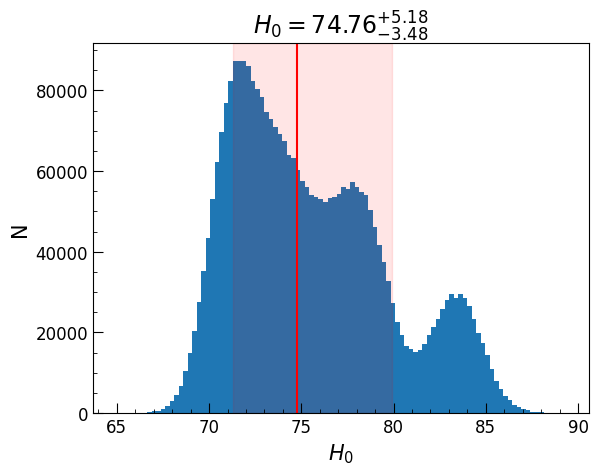

In [366]:
fig, ax = plt.subplots()

#Get the median and 1sigma errors
lo_val = np.percentile(H0_samples, 16)
med_val = np.median(H0_samples)
hi_val = np.percentile(H0_samples, 84)


ax.hist(H0_samples, bins=100)
ax.axvline(med_val, color='r')
ax.axvspan(lo_val, hi_val, color='r', alpha=.1)

ax.set_xlabel(r'$H_0$', fontsize=15)
ax.set_ylabel('N', fontsize=15)
ax.set_title(r'$H_0 = ' + '{:.2f}'.format(med_val) + '^{+'  + '{:.2f}'.format(hi_val-med_val) + '}_{-' + '{:.2f}'.format(med_val-lo_val) + r'}$',
            fontsize=17)
plt.show()

This is the histogram of "$H_0$ samples", plugging in the $\Delta\mu_i$ samples from the MCMC run to the equation from Q4. The red line shows the median of the samples, and the shaded red region shows the $\pm 1\sigma$ interval around the median. The median value and its errors (using the $\pm 1 \sigma$ interval) are shown above the plot.

Using the MCMC run samples and plugging in gives a median estimate of: $H_0 = 74.76^{+5.18}_{-3.50}$

Riess et al. (2011) value: $H_0 = 74.8^{+3}_{-3}$

My value fits well within the uncertainty of the value found by Riess et al. (2011).